In [1]:
from numpy.linalg import qr, svd

from scipy.linalg import subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

import os
import sys
parent_dir = os.path.dirname(os.getcwd())  
sys.path.append(parent_dir)
from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

import jPCA

R2 etc (PSTH)

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_78882/98104984.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_78882/98104984.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_78882/98104984.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_78882/98104984.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLo

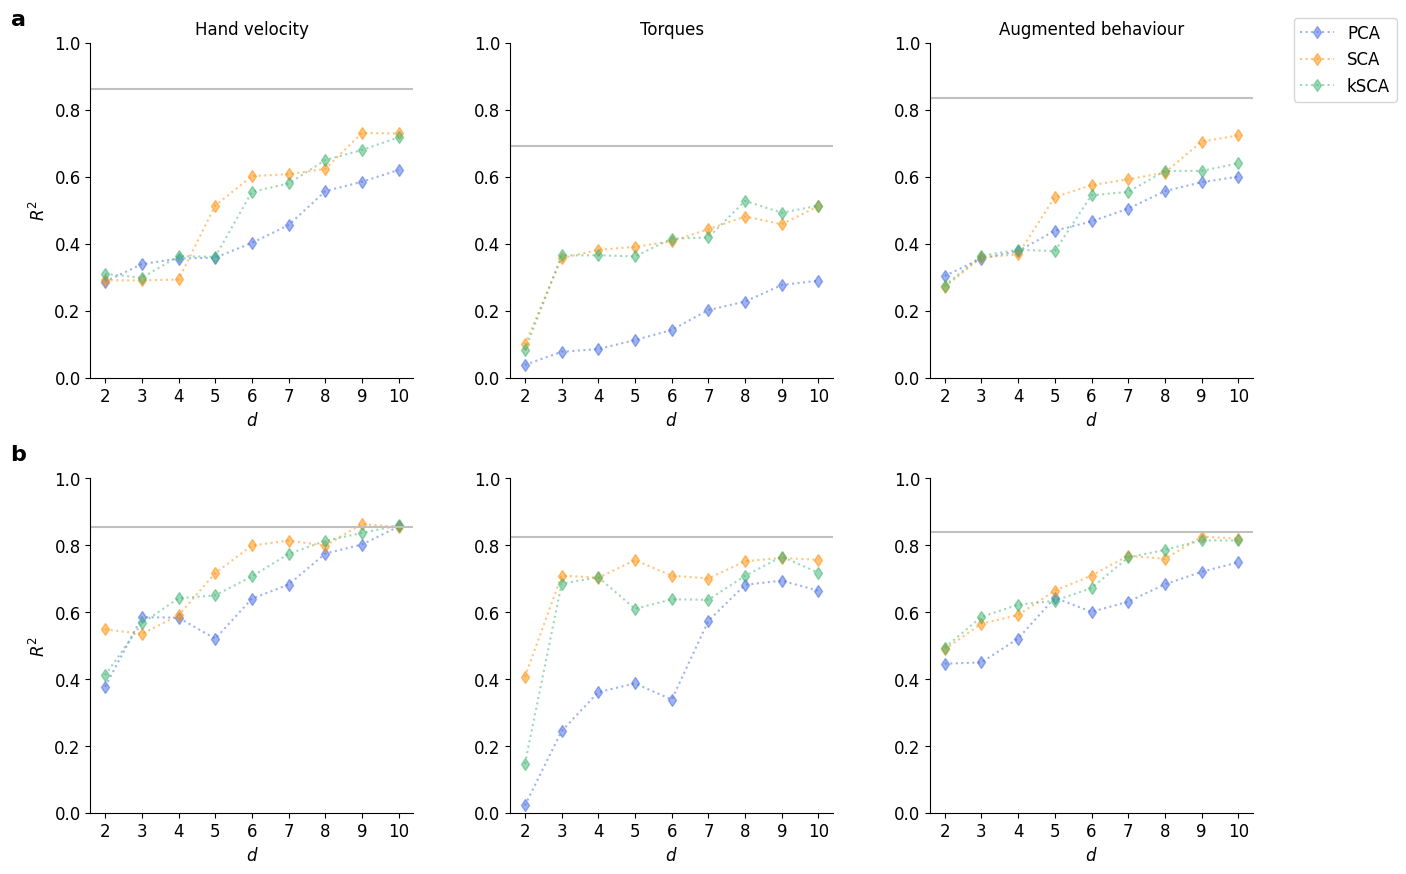

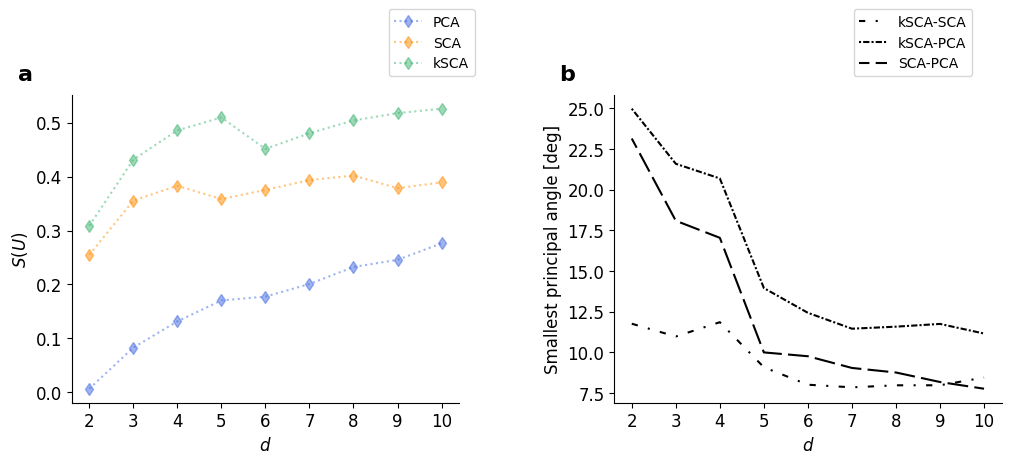

In [18]:
path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2'

r2_ridge_hand_vel = [f'{path}/psth_hand_vel/ls_r2_pca.npy',
                     f'{path}/psth_hand_vel/ls_r2_sca.npy',
                     f'{path}/psth_hand_vel/ls_r2_ksca.npy']

r2_ridge_torques  = [f'{path}/psth_torques/ls_r2_pca.npy',
                     f'{path}/psth_torques/ls_r2_sca.npy',
                     f'{path}/psth_torques/ls_r2_ksca.npy']

r2_ridge_aug_behaviour  = [f'{path}/psth_aug_behaviour/ls_r2_pca.npy',
                           f'{path}/psth_aug_behaviour/ls_r2_sca.npy',
                           f'{path}/psth_aug_behaviour/ls_r2_ksca.npy']



su = [f'{path}/psth_hand_vel/ls_su_pca.npy',
               f'{path}/psth_hand_vel/ls_su_sca.npy',
               f'{path}/psth_hand_vel/ls_su_ksca.npy']

principal_angle = [f'{path}/psth_hand_vel/ls_principal_angle_kSCA_SCA.npy',
                   f'{path}/psth_hand_vel/ls_principal_angle_kSCA_PCA.npy',
                   f'{path}/psth_hand_vel/ls_principal_angle_SCA_PCA.npy']

def plot_data(ax, file_paths, labels, colors):
    for i, (file_path, label) in enumerate(zip(file_paths, labels)):
        data = np.load(file_path)
        ax.plot(data, label=label, color=colors[i], alpha=0.5, marker='d', linestyle=':')

colors= ['royalblue', 'darkorange', 'mediumseagreen']
fontsize = 12 
labels = ['PCA', 'SCA', 'kSCA']
ls_behaviour = ['hand_vel', 'torques', 'aug_behaviour']

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_data(axs[0, 0], r2_ridge_hand_vel, labels, colors)
plot_data(axs[0, 1], r2_ridge_torques, labels, colors)
plot_data(axs[0, 2], r2_ridge_aug_behaviour, labels, colors)

for i, behaviour in enumerate(ls_behaviour):
    r2_x = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/psth_{behaviour}/r2_X.npy')
    axs[0,i].axhline(r2_x, linestyle='-', color='silver')

ds = np.arange(2,11)
for i, behaviour in enumerate(ls_behaviour):
    ls_ksca = []
    ls_sca = []
    ls_pca = []
    for d in ds:
        ls_ksca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian NN/{behaviour}/gaussian_{d}_r2 .npy') )
        ls_sca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian NN/{behaviour}/linear_{d}_r2 .npy') )
        ls_pca.append(np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian NN/{behaviour}/pca_{d}_r2 .npy') )
    axs[1,i].plot(ls_pca, label='PCA', color=colors[0], alpha=0.5, marker='d', linestyle=':')
    axs[1,i].plot(ls_sca, label='SCA', color=colors[1], alpha=0.5, marker='d', linestyle=':')
    axs[1,i].plot(ls_ksca, label='kSCA', color=colors[2], alpha=0.5, marker='d', linestyle=':')

for i, behaviour in enumerate(ls_behaviour):
    r2_x = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/Gaussian NN/{behaviour}/neural_r2.npy')
    axs[1,i].axhline(r2_x, linestyle='-', color='silver')

axs[0,0].set_ylabel(r"$R^2$", fontsize = fontsize)
axs[1,0].set_ylabel(r"$R^2$", fontsize =fontsize)

axs[0,0].set_title('Hand velocity', fontsize=fontsize)
axs[0,1].set_title('Torques', fontsize=fontsize)
axs[0,2].set_title('Augmented behaviour', fontsize=fontsize)
# axs[1,0].set_title('Hand velocity \n (Gaussian NN)', fontsize=fontsize)
# axs[1,1].set_title('Torques \n (Gaussian NN)', fontsize=fontsize)
# axs[1,2].set_title('Augmented behaviour \n (Gaussian NN)', fontsize=fontsize)
axs[0, 2].legend(fontsize=fontsize, loc='upper left', bbox_to_anchor=(1.1, 1.1))

for row in range(axs.shape[0]):  # Loop over the rows
    for ax in axs[row]:  # Loop over each axis in the current row
        ax.set_xlabel(r"$d$", fontsize=fontsize)
        ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
        ax.set_xticks(np.arange(len(ds)), ds)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

        if row == 0:
            ax.set_ylim([0, 1])  # First row y-limits
        elif row == 1:
            ax.set_ylim([0, 1])

for i, label in enumerate(['a', 'b']):
    axs[i, 0].text(-0.2, 1.1, label, transform=axs[i, 0].transAxes, fontsize=fontsize+4, fontweight='bold', va='top', ha='right')
plt.subplots_adjust(hspace=0.3, wspace=0.3)


fig, axs = plt.subplots(1,2, figsize=(12,4))
plot_data(axs[0], su, labels, colors)
axs[0].set_ylabel(r"$S(U)$", fontsize=fontsize)

axs[1].plot(np.load(principal_angle[0]), color='black', linestyle=(0, (3, 5, 1, 5)), label='kSCA-SCA')
axs[1].plot(np.load(principal_angle[1]), color='black', linestyle = (10,(3, 1, 1, 1)), label='kSCA-PCA')
axs[1].plot(np.load(principal_angle[2]), color='black', linestyle=(5, (10, 3)), label='SCA-PCA')

axs[1].set_ylabel('Smallest principal angle [deg]', fontsize=fontsize)
for ax in axs:
    ax.set_xlabel(r"$d$", fontsize=fontsize)
    ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
    ax.set_xticks(np.arange(len(ds)), ds)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
for i, label in enumerate(['a', 'b']):
    axs[i].text(-0.1, 1.1, label, transform=axs[i].transAxes, fontsize=fontsize+4, fontweight='bold', va='top', ha='right')
plt.subplots_adjust(wspace=0.4)

axs[0].legend(fontsize=10, loc='upper left', bbox_to_anchor=(0.8, 1.3)) #
axs[1].legend(fontsize=10, loc='upper left', bbox_to_anchor=(0.6, 1.3)) 

R2 etc (single trials)

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_78882/1524584914.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_78882/1524584914.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_78882/1524584914.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)


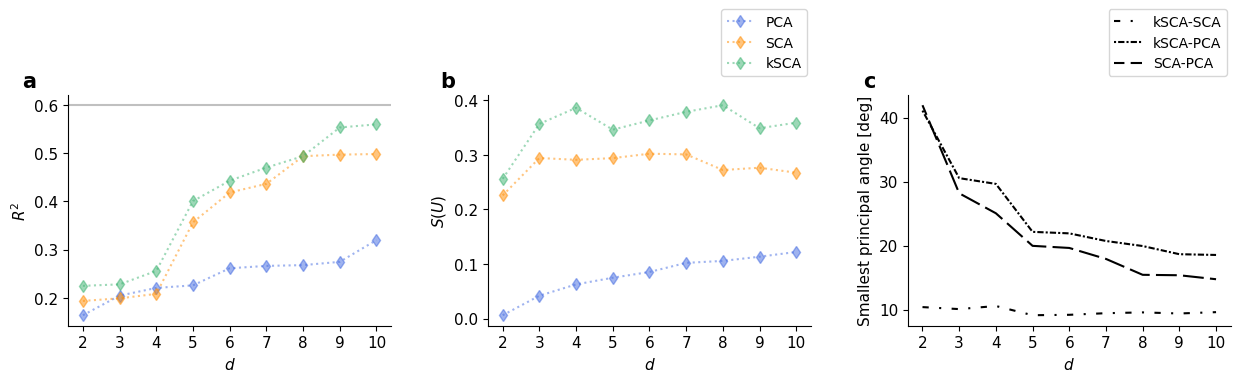

In [13]:
path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2'

r2_ridge_hand_vel = [f'{path}/spikes_hand_vel/ls_r2_pca.npy',
                     f'{path}/spikes_hand_vel/ls_r2_sca.npy',
                     f'{path}/spikes_hand_vel/ls_r2_ksca.npy']

su = [f'{path}/spikes_hand_vel/ls_su_pca.npy',
      f'{path}/spikes_hand_vel/ls_su_sca.npy',
      f'{path}/spikes_hand_vel/ls_su_ksca.npy']

principal_angle = [f'{path}/spikes_hand_vel/ls_principal_angle_kSCA_SCA.npy',
                   f'{path}/spikes_hand_vel/ls_principal_angle_kSCA_PCA.npy',
                   f'{path}/spikes_hand_vel/ls_principal_angle_SCA_PCA.npy']

fontsize = 11
fig, axs = plt.subplots(1,3, figsize=(15,3))
plot_data(axs[0], r2_ridge_hand_vel, labels, colors)
axs[0].set_ylabel(r"$R^2$", fontsize=fontsize)
r2_x = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/results/R2/spikes_hand_vel/r2_X.npy')
axs[0].axhline(r2_x, linestyle='-', color='silver')

plot_data(axs[1], su, labels, colors)
axs[1].set_ylabel(r"$S(U)$", fontsize=fontsize)

axs[2].plot(np.load(principal_angle[0]), color='black', linestyle=(0, (3, 5, 1, 5)), label='kSCA-SCA')
axs[2].plot(np.load(principal_angle[1]), color='black', linestyle = (10,(3, 1, 1, 1)), label='kSCA-PCA')
axs[2].plot(np.load(principal_angle[2]), color='black', linestyle=(5, (10, 3)), label='SCA-PCA')

axs[2].set_ylabel('Smallest principal angle [deg]', fontsize=fontsize)
for ax in axs:
    ax.set_xlabel(r"$d$", fontsize=fontsize)
    ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
    ax.set_xticks(np.arange(len(ds)), ds)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
for i, label in enumerate(['a', 'b', 'c']):
    axs[i].text(-0.1, 1.1, label, transform=axs[i].transAxes, fontsize=fontsize+4, fontweight='bold', va='top', ha='right')
plt.subplots_adjust(wspace=0.3)

axs[1].legend(fontsize=10, loc='upper left', bbox_to_anchor=(0.7, 1.4)) #
axs[2].legend(fontsize=10, loc='upper left', bbox_to_anchor=(0.6, 1.4)) 

PLOTTING Projections

Text(0.775, 1, 'kSCA')

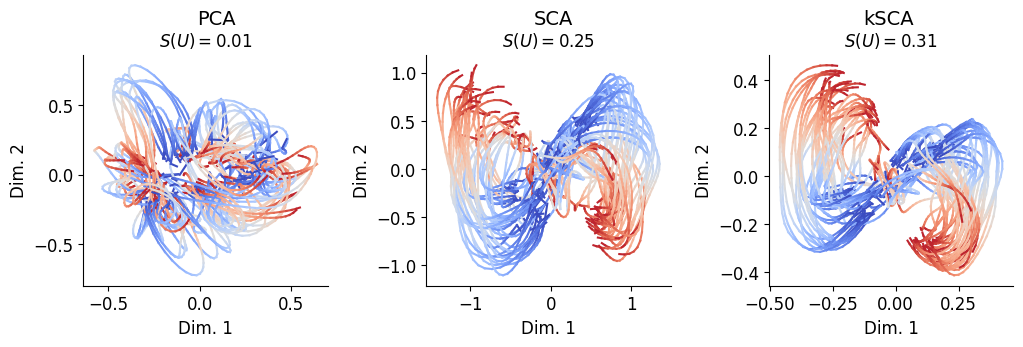

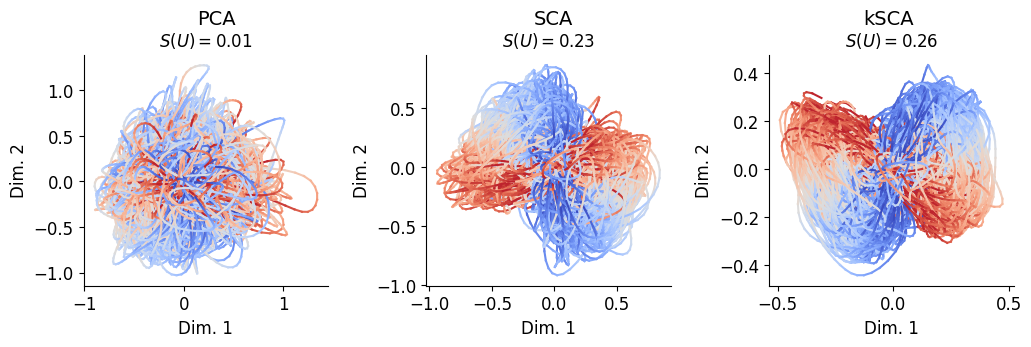

In [5]:
path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/'

ls_projections_2D = [f'{path}/pca_psth/Y_pca_2d.npy',
                     f'{path}/kernel_/neural_psth/projection_2d_linear.npy',
                     f'{path}/kernel_/neural_psth/projection_2d_gaussian.npy']


ls_projections_2D_individual_trials = [f'{path}/pca_spikes/Y_pca_2d.npy',
                     f'{path}/kernel_/neural_spikes/projection_2d_linear.npy',
                     f'{path}/kernel_/neural_spikes/projection_2d_gaussian.npy']

ls_projections_3D = [f'{path}/pca_psth/Y_pca_3d.npy',
                     f'{path}/kernel_/neural_psth/projection_3d_linear.npy',
                     f'{path}/kernel_/neural_psth/projection_3d_gaussian.npy']

def plot_2D(ax, Y, fontsize=fontsize):
    cmap = plt.get_cmap('coolwarm')
    num_time_points = Y.shape[-1]
    indices_to_plot = np.arange(0, Y.shape[0], 1)
    for i in indices_to_plot:
        x = Y[i, 0, :]
        y = Y[i, 1, :]
        for t in range(num_time_points - 1):
            ax.plot(x[t:t+2], y[t:t+2], color=cmap(t / (num_time_points - 1)))
    ax.set_xlabel('Dim. 1', fontsize=fontsize)
    ax.set_ylabel('Dim. 2', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    SU = np.abs(compute_S_all_pairs(jnp.array(Y)))
    ax.set_title(r'$S(U) = {:.2f}$'.format(np.minimum(SU, 1.00)), fontsize=fontsize)
    ax.spines[['top','right']].set_visible(False)
    ax.grid(False) 

def plot_3D(ax, Y, fontsize=fontsize):
    cmap = plt.get_cmap('coolwarm')
    num_time_points = Y.shape[-1]
    indices_to_plot = np.arange(0, Y.shape[0], 1)
    for i in indices_to_plot:
        x = Y[i, 0, :]
        y = Y[i, 1, :]
        z = Y[i, 2, :]
        for t in range(num_time_points - 1):
            ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))
    ax.set_xlabel('Dim. 1', fontsize=fontsize)
    ax.set_ylabel('Dim. 2', fontsize=fontsize)
    ax.set_zlabel('Dim. 3', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)  
    ax.tick_params(axis='z', labelsize=fontsize)
    SU = np.abs(compute_S_all_pairs(jnp.array(Y)))
    ax.set_title(r'$S(U) = {:.2f}$'.format(np.minimum(SU, 1.00)), fontsize=fontsize)
    ax.spines[['top','right']].set_visible(False)
    ax.grid(False) 

fontsize=12 
fontsize_big = 14
fig = plt.figure(figsize=(12, 3))
axs = [fig.add_subplot(1, 3, i + 1) for i in range(3)]
for i, path in enumerate(ls_projections_2D):
    data = np.load(path)
    plot_2D(axs[i], data)
plt.subplots_adjust(wspace=0.4)
#fig.text(0.05, 1, 'a', va='center', rotation='horizontal', fontsize=fontsize_big, fontweight='bold')
fig.text(0.22, 1, 'PCA', va='center', rotation='horizontal', fontsize=fontsize_big)
fig.text(0.5, 1, 'SCA', va='center', rotation='horizontal', fontsize=fontsize_big)
fig.text(0.775, 1, 'kSCA', va='center', rotation='horizontal', fontsize=fontsize_big)

fig = plt.figure(figsize=(12, 3))
axs = [fig.add_subplot(1, 3, i + 1) for i in range(3)]
for i, path in enumerate(ls_projections_2D_individual_trials):
    data = np.load(path)
    plot_2D(axs[i], data)
plt.subplots_adjust(wspace=0.4)
#fig.text(0.05, 1, 'a', va='center', rotation='horizontal', fontsize=fontsize_big, fontweight='bold')
fig.text(0.22, 1, 'PCA', va='center', rotation='horizontal', fontsize=fontsize_big)
fig.text(0.5, 1, 'SCA', va='center', rotation='horizontal', fontsize=fontsize_big)
fig.text(0.775, 1, 'kSCA', va='center', rotation='horizontal', fontsize=fontsize_big)




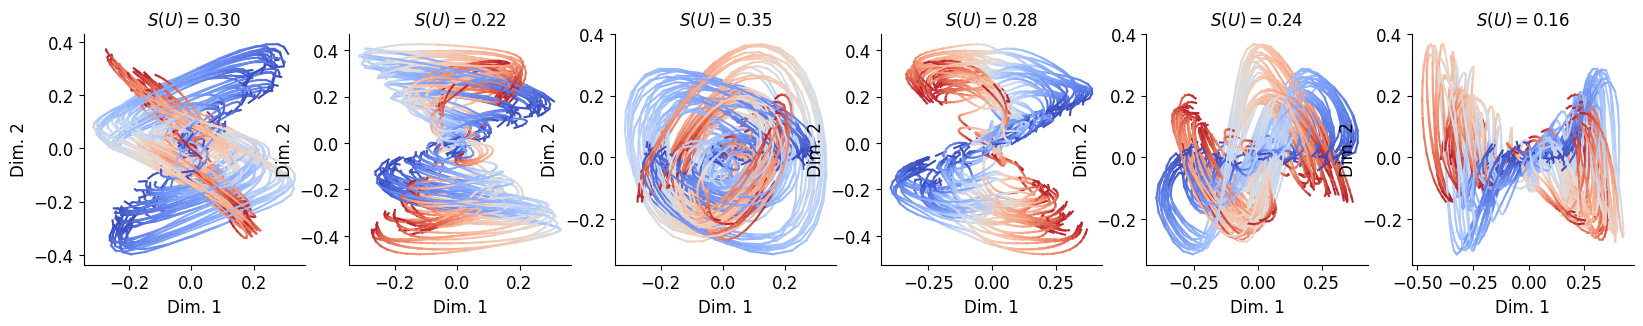

In [39]:
path = '/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/'
test = np.load(f'{path}/kernel_/neural_psth/projection_4d_gaussian.npy')

fig, axs = plt.subplots(1,6, figsize=(20,3))
ids = [0,1]
plot_2D(axs[0], test[:,ids, :])
ids = [0,2]
plot_2D(axs[1], test[:,ids, :])
ids = [0,3]
plot_2D(axs[2], test[:,ids, :])
ids = [1,2]
plot_2D(axs[3], test[:,ids, :])
ids = [1,3]
plot_2D(axs[4], test[:,ids, :])
ids = [2,3]
plot_2D(axs[5], test[:,ids, :])

Text(0.05, 1, 'b')

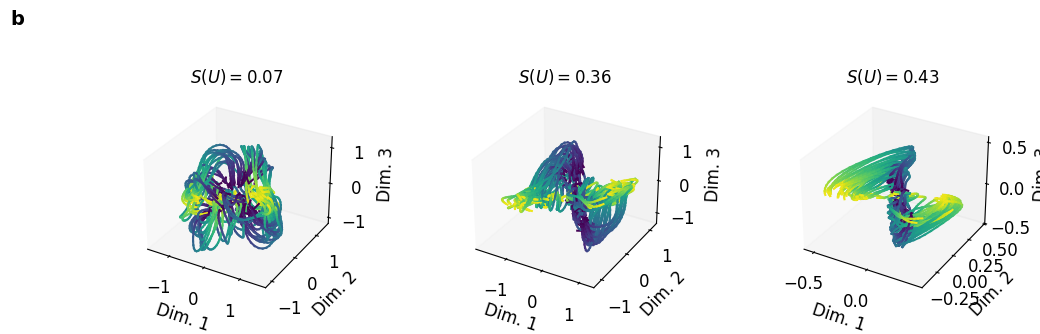

In [54]:
fig = plt.figure(figsize=(12, 6))
axs = [fig.add_subplot(2, 3, i + 1, projection='3d') for i in range(3)]
for i, path in enumerate(ls_projections_3D):
    data = np.load(path)
    plot_3D(axs[i], data)

fig.text(0.05, 1, 'b', va='center', rotation='horizontal', fontsize=fontsize_big, fontweight='bold')